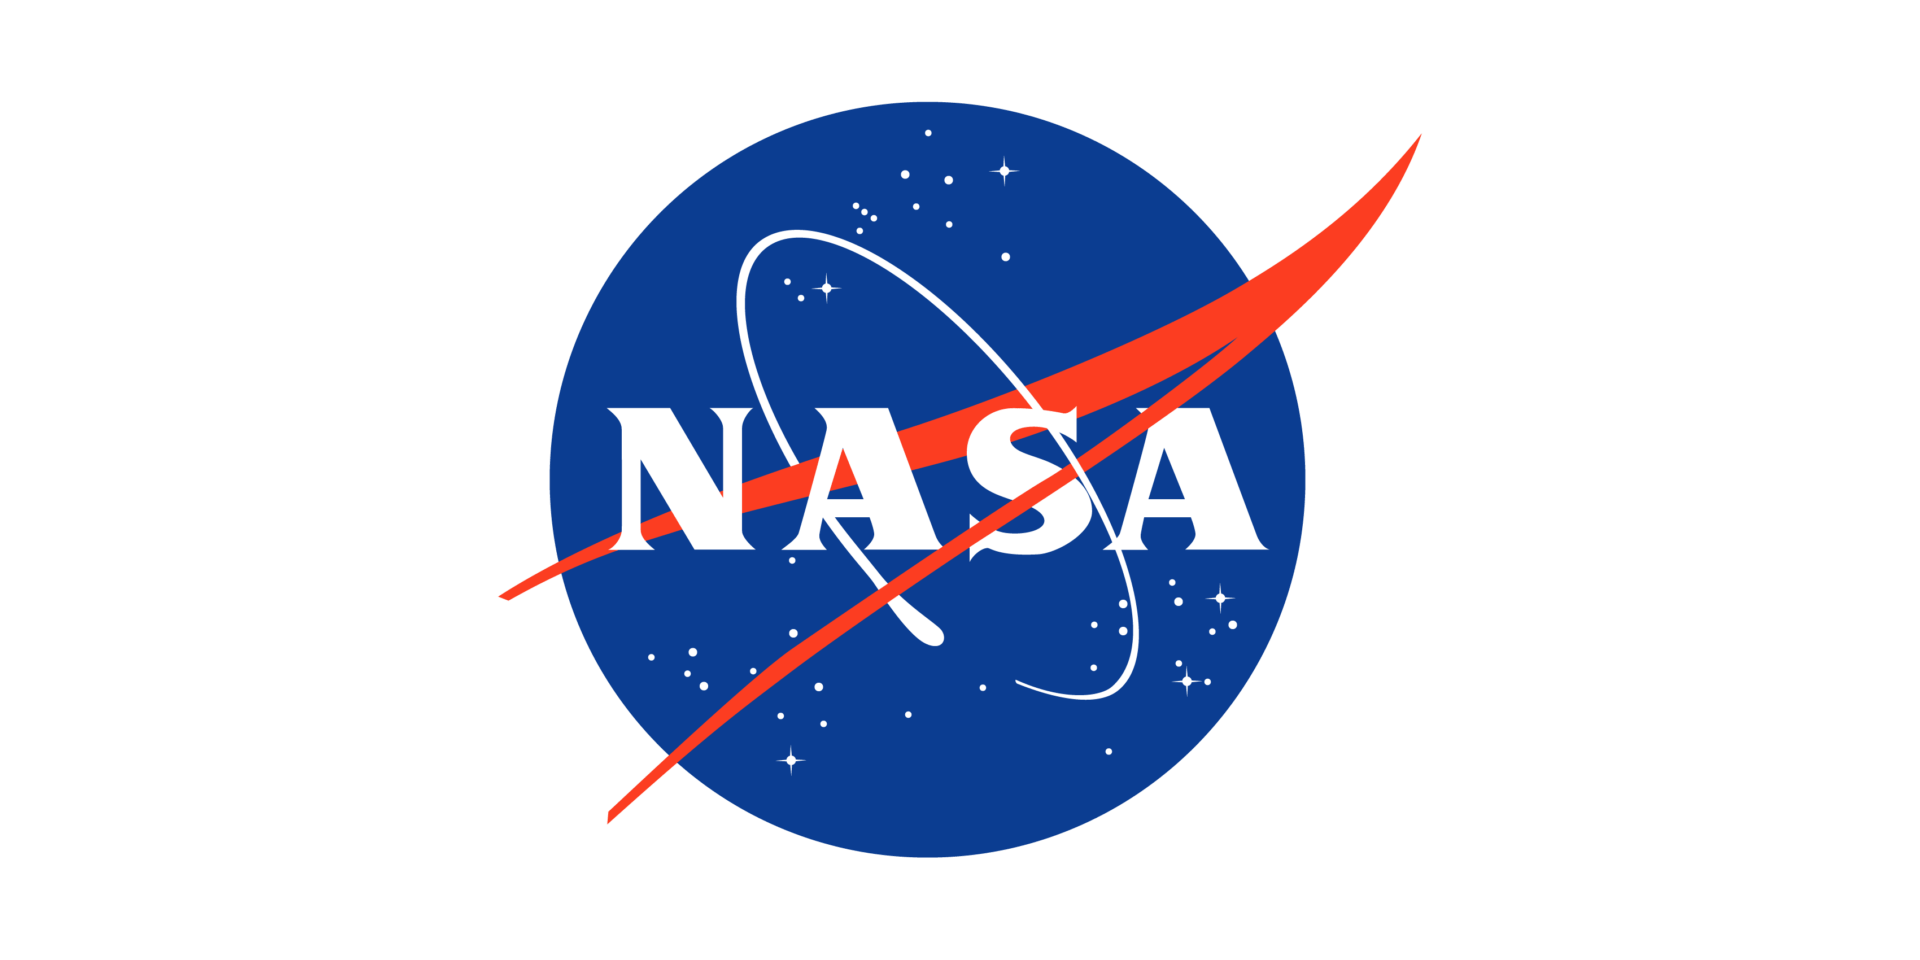

Você trabalha na central de controle da Nasa

Sua missão é:
coletar informações de choques energéticos no espaço,
monitorar explosões na superfície do sol e 
recuperar imagens do espaço para estudo adicional

Boa sorte!🫡🧑‍🚀

In [139]:
import requests
import pandas as pd
from pandas import json_normalize
import datetime
import os
import platform
import win32com.client as win32
import socket
import warnings
warnings.simplefilter('ignore')

In [140]:
#bônus: monitoramento da rotina do API
nome_rotina = 'Fluxo de dados - APIs NASA'

#identificar o usuário
def identificando_usuario():
	#capturar usuário
	usuario = os.environ.get('USERNAME')
	#capturar a máquina
	maquina = platform.node()
	#capturar o sistema operacional
	sistema_operacional = platform.platform()
	#retorno da função
	return usuario, maquina, sistema_operacional
		
#verificando conexão de internet
def verificar_conexao():
		URL = ['https://api.nasa.gov/planetary/apod','https://api.nasa.gov/DONKI/IPS?', 'https://api.nasa.gov/DONKI/FLR?' ]
		#tempo para conexão (em segundos)
		timeout = 5
		try:
			for item in URL:
				requests.get(item, timeout=timeout)
				return True
		except:
			return False
#identificando o IP da pessoa
def identificando_ip():
		try:
		#identificando IP local da pessoa
			ip_local = socket.gethostbyname(socket.gethostname())
			return ip_local
		except:
			return False

In [141]:
#identificar o início
def inicio_rotina():
	#data de início
	data_inicio = datetime.datetime.today().date()
	#hora de início
	hora_inicio = datetime.datetime.now()
	#retorno
	return data_inicio, hora_inicio

lista_inicio = inicio_rotina()

In [142]:
class API_NASA:

    def __init__(self):
        #chave para acesso aos APIs
        self.nasa_key = 'qM1CGrGFcGQymERYupWhCzNHwSbw4jwc6hpbZ5WE'
        #solicitar a data da rquisição 
        self.data_ini_usu = self.solicitar_data("Digite a data inicial (dd/mm/aaaa): ")
        self.data_fim_usu = self.solicitar_data("Digite a data final (dd/mm/aaaa): ")
        #solicitar o caminho que será salvo
        self.caminho_pasta = input("Digite o caminho da pasta: ").replace('"', '')
        #ajustar o cominho para salvar cada API de acordo com o nome designado para o API
        self.caminho_apod =  os.path.join(self.caminho_pasta, "api_apod.parquet")
        self.caminho_ips = os.path.join(self.caminho_pasta, "api_ips.parquet")
        self.caminho_flare = os.path.join(self.caminho_pasta, "api_flare.parquet")

    def solicitar_data(self, mensagem):
        #mensagem para usuário
        data = input(mensagem)
        #ajustar data para um formato que o API aceite
        return datetime.datetime.strptime(data, '%d/%m/%Y').strftime('%Y-%m-%d')

    # solicitar no API e salvar em parquet
    def api_apod(self):
    #url do API
        url = 'https://api.nasa.gov/planetary/apod'
        #parâmetros do API
        parametros = {
            'start_date': self.data_ini_usu,
            'end_date': self.data_fim_usu,
            'hd':True,
            'api_key': self.nasa_key
            }
        # método GET
        response = requests.get(url,params=parametros).json()
        #transformar json in DataFrame
        df_apod = json_normalize(response)
        #caso DF vazio
        if df_apod.empty:
            print(f'Nenhum dado encontrado entre {self.data_ini_usu} e {self.data_fim_usu}')
        else: 
        #selecionar e renomar colunas
            df_apod = df_apod[['date','title','url']]
            df_apod = df_apod.set_axis(['data', 'titulo', 'url'], axis=1)
            #verificar se o arquivo já existe e transformar em parquet
            if os.path.exists(self.caminho_apod):
                df_existente = pd.read_parquet(self.caminho_apod)
                df_completo = pd.concat([df_existente,df_apod]).drop_duplicates().reset_index(drop=True)
            else:
                df_completo = df_apod
            df_completo.to_parquet(self.caminho_apod)
                
    def api_ips(self):
        url = 'https://api.nasa.gov/DONKI/IPS?'
        parametros = {
            'startDate': self.data_ini_usu,
            'endDate': self.data_fim_usu,
            'api_key': self.nasa_key
        }
        response = requests.get(url,params=parametros).json()
        df_ips = json_normalize(response)
        if df_ips.empty:
            print(f'Nenhum dado encontrado entre {self.data_ini_usu} e {self.data_fim_usu}')
        else:
            df_ips = df_ips[['activityID','location', 'eventTime', 'link']]
            df_ips = df_ips.set_axis(['ID','local', 'data', 'url'], axis=1)
            if os.path.exists(self.caminho_ips):
                df_existente = pd.read_parquet(self.caminho_ips)
                df_completo = pd.concat([df_existente,df_ips]).drop_duplicates().reset_index(drop=True)
            else:
                df_completo = df_ips
            df_completo.to_parquet(self.caminho_ips)

    def api_flare(self):
        url = 'https://api.nasa.gov/DONKI/FLR?'
        parametros = {
            'startDate': self.data_ini_usu,
            'endDate': self.data_fim_usu,
            'api_key': self.nasa_key
            }
        response = requests.get(url,params=parametros).json()
        df_flare = json_normalize(response)
        if df_flare.empty:
            print(f'Nenhum dado encontrado entre {self.data_ini_usu} e {self.data_fim_usu}')
        else:
            df_flare = df_flare[['flrID','beginTime','peakTime', 'endTime', 'classType','sourceLocation', 'link' ]]
            df_flare = df_flare.set_axis(['ID','inicio', 'pico', 'fim', 'tipo', 'local_fonte', 'url'], axis=1)
            if os.path.exists(self.caminho_flare):
                df_existente = pd.read_parquet(self.caminho_flare)
                df_completo = pd.concat([df_existente, df_flare]).drop_duplicates().reset_index(drop=True)
            else: 
                df_completo = df_flare
            df_completo.to_parquet(self.caminho_flare)


In [143]:
classe = API_NASA()
classe.api_apod()    # Chama o método api_apod()
classe.api_ips()     # Chama o método api_ips()
classe.api_flare()   # Chama o método api_flare()

In [144]:
#identificar o término
def termino_rotina():
	#data de término
	data_termino = datetime.datetime.today().date()
	#hora de término
	hora_termino = datetime.datetime.now()
	#retorno
	return data_termino, hora_termino

lista_termino = termino_rotina()

In [145]:
lista_usuario = identificando_usuario()
conexao_internet = verificar_conexao()	
verificando_ip = identificando_ip()

In [146]:
#calcular o tempo de execução em milissegundos
tempo_execuçao = (lista_termino[1] - lista_inicio[1])
tempo_execuçao = tempo_execuçao.days * 24 * 3600 + tempo_execuçao.seconds + tempo_execuçao.microseconds / 1000000
tempo_execuçao= f"{tempo_execuçao} segundos"

dicionario = {
'nome_rotina' : nome_rotina,
'usuario' : lista_usuario[0],
'maquina' : lista_usuario[1],
'sistema_operacional' : lista_usuario[2],
'data_inicio' : lista_inicio[0],
'horario_inicio' : lista_inicio[1],
'teste_conexao' : conexao_internet,
'ip_local' : verificando_ip,
'data_termino' : lista_termino[0],
'horario_termino' : lista_termino[1],
'tempo_execuçao' : tempo_execuçao,
}

#criar dataframe com as informações
tabela_log = pd.DataFrame(dicionario, index=[0])
tabela_log

Tempo de início: 2024-10-24 14:19:22.149705
Tempo de término: 2024-10-24 14:20:38.421042
76.271337


,nome_rotina,usuario,maquina,sistema_operacional,data_inicio,horario_inicio,teste_conexao,ip_local,data_termino,horario_termino,tempo execuçao
0,Fluxo de dados - APIs NASA,Maria,LAPTOP-ILEK6NP6,Windows-11-10.0.22631-SP0,2024-10-24,2024-10-24 14:19:22.149705,True,192.168.0.9,2024-10-24,2024-10-24 14:20:38.421042,76.271337 segundos
